In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, utils
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_image = cv2.imread("sample.png")[..., ::-1]
image = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
])(raw_image.copy()).unsqueeze(0)

In [3]:
image.shape

torch.Size([1, 3, 495, 835])

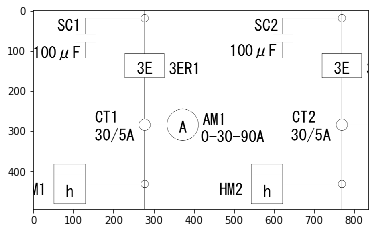

In [4]:
plt.imshow(raw_image)

In [5]:
#raw_template = raw_image[20:100, 570:650,:]
raw_template = raw_image[100:170, 220:330, :]
#raw_template = cv2.resize(raw_template, dsize=None, fx=0.7, fy=0.7)

In [6]:
(220+330)/2

275.0

In [7]:
raw_template.shape

(70, 110, 3)

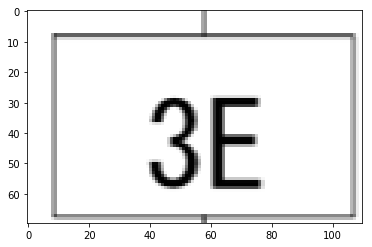

In [8]:
plt.imshow(raw_template)

In [9]:
template = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
])(raw_template.copy()).unsqueeze(0)

In [13]:
class FeatureExtractor():
    def __init__(self, model, use_cuda=True, padding=False):
        self.model = model
        self.use_cuda = use_cuda
        self.feature_maps = []
        
        if self.use_cuda:
            self.model = self.model.cuda()
            
        self.index = []
        self.f = []
        self.stride = []
        for i, module in enumerate(self.model.children()):
            if isinstance(module, nn.Conv2d):
                self.index.append(i)
                self.f.append(module.kernel_size[0])
                self.stride.append(module.stride[0])
            if isinstance(module, nn.MaxPool2d):
                if padding:
                    module.padding = 1
                self.index.append(i)
                self.f.append(module.kernel_size)
                self.stride.append(module.stride)
        
        self.rf = np.array(self.calc_rf(self.f, self.stride))
        
    def save_template_feature_map(self, module, input, output):
        self.template_feature_map = output.detach()
        
    def save_image_feature_map(self, module, input, output):
        self.image_feature_map = output.detach()
                
    def calc_rf(self, f, stride):
        rf = []
        for i in range(len(f)):
            if i == 0:
                rf.append(3)
            else:
                rf.append(rf[i-1] + (f[i]-1)*self.product(stride[:i]))
        return rf
    
    def product(self, lis):
        if len(lis) == 0:
            return 0
        else:
            res = 1
            for x in lis:
                res *= x
            return res
    
    def calc_l_star(self, template, k=3):
        l = np.sum(self.rf <= min(list(template.size()[-2:]))) - 1
        l_star = max(l - k, 1)
        return l_star
    
    def calc_NCC(self, F, M):
        h_f, w_f = F.shape[-2:]
        NCC = np.zeros((M.shape[-2] - h_f, M.shape[-1] - w_f))
        for i in range(M.shape[-2] - h_f):
            for j in range(M.shape[-1] - w_f):
                M_tilde = M[:,:, i:i+h_f, j:j+w_f]
                NCC[i, j] = np.sum((M_tilde * F)/(np.linalg.norm(M_tilde)*np.linalg.norm(F)))
        return NCC

    def __call__(self, template, image):
        if self.use_cuda:
            template = template.cuda()
            image = image.cuda()
            
        self.l_star = self.calc_l_star(template)
        
        template_handle = self.model[self.index[self.l_star]].register_forward_hook(self.save_template_feature_map)
        self.model(template)
        template_handle.remove()
        
        image_handle = self.model[self.index[self.l_star]].register_forward_hook(self.save_image_feature_map)
        self.model(image)
        image_handle.remove()
        
        if self.use_cuda:
            self.template_feature_map = self.template_feature_map.cpu()
            self.image_feature_map = self.image_feature_map.cpu()
            
        self.NCC = self.calc_NCC(self.template_feature_map.numpy(), self.image_feature_map.numpy())
        i_star, j_star = np.unravel_index(np.argmax(self.NCC), self.NCC.shape)
        NCC_part = self.NCC[i_star-1:i_star+2, j_star-2:j_star+2]
        
        x_center = (j_star + self.template_feature_map.size()[-1]/2) * image.size()[-1] // self.image_feature_map.size()[-1]
        y_center = (i_star + self.template_feature_map.size()[-2]/2 )* image.size()[-2] // self.image_feature_map.size()[-2]
        
        x1_0 = x_center - template.size()[-1]/2
        x2_0 = x_center + template.size()[-1]/2
        y1_0 = y_center - template.size()[-2]/2
        y2_0 = y_center + template.size()[-2]/2
        
        stride_product = self.product(self.stride[:self.l_star])
        
        x1 = np.sum(NCC_part * (x1_0 + np.array([-2, -1, 0, 1]) *  stride_product)[None, :]) / np.sum(NCC_part)
        x2 = np.sum(NCC_part * (x2_0 + np.array([-2, -1, 0, 1]) *  stride_product)[None, :]) / np.sum(NCC_part)
        y1 = np.sum(NCC_part * (y1_0 + np.array([-1, 0, 1]) * stride_product)[:, None]) / np.sum(NCC_part)
        y2 = np.sum(NCC_part * (y2_0 + np.array([-1, 0, 1]) * stride_product)[:, None]) / np.sum(NCC_part)
        
        x1 = int(round(x1))
        x2 = int(round(x2))
        y1 = int(round(y1))
        y2 = int(round(y2))
        x_center = int(round(x_center))
        y_center = int(round(y_center))

        return (x1, y1), (x2, y2), (x_center, y_center)

In [14]:
FE = FeatureExtractor(models.vgg13(pretrained=True).features, use_cuda=True)

In [15]:
(x1, y1), (x2, y2), (x_center, y_center) = FE(template, image)

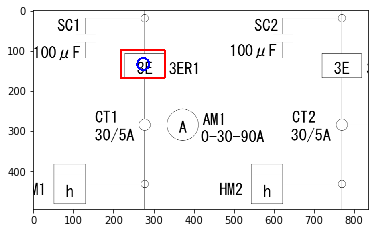

In [16]:
d_img = cv2.rectangle(raw_image.astype(np.uint8), (x1, y1), (x2, y2), (255,0,0), 3)
d_img = cv2.circle(d_img, (int(x_center), int(y_center)), 15, (0,0,255), 3)
plt.imshow(d_img)

In [133]:
x_center, y_center

(274.0, 134.0)

In [134]:
x1, y1

(218, 99)

In [135]:
x2, y2

(328, 169)

In [136]:
(x1 + x2)/2

273.0

In [137]:
(y1 + y2)/2

134.0

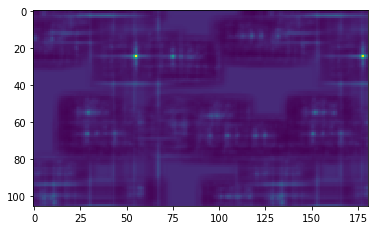

In [138]:
NCC = FE.NCC / np.max(FE.NCC)
plt.imshow(NCC)